In [224]:
# Imports
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.initializers import GlorotUniform, RandomNormal
from tensorflow.keras.models import load_model
print ("TensorFlow version: " + tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
import os
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


TensorFlow version: 2.17.0


Load Dataset
 Each File has 31 rows and 4 columns. The first 3 columns indicate heart rate, respiratory rate, and oxygen saturation of a baby; the last column indicates if the baby is in pain or not (0 means no pain, 1 means slight pain, 2 means severe pain, # means label is missing).


In [225]:
data_dir = "./Data/"
csv_files = glob.glob(data_dir + "/**/*.csv", recursive=True) # get all csv files in the data directory
combined_csv = pd.concat([pd.read_csv(f, header=None) for f in csv_files], ignore_index=True) # combine all csv files into one dataframe
combined_csv.drop(columns=[0], inplace=True) # drop the first column (index)
combined_csv = combined_csv[combined_csv.iloc[:, 3] != "#"] # remove rows with "#" in the 4th column
combined_csv = combined_csv[combined_csv.iloc[:, 2] != "--1"] # remove row with "--1" in the 3rd column (why is that there?)
combined_csv # display the combined dataframe


,1,2,3,4
0,142,60,100,0
1,142,60,100,0
2,142,60,100,0
3,142,59,100,0
4,143,59,100,0
...,...,...,...,...
18657,169,19,98,1
18658,164,50,98,1
18659,164,74,98,1
18660,162,39,99,1


In [226]:
#  Shuffle dataset
combined_csv = shuffle(combined_csv)

In [227]:
# Split Dataset
train, test = train_test_split(combined_csv, test_size=0.1) 
train, valid = train_test_split(combined_csv, test_size=0.1) # split the dataset into 90% training and 10% validation (test) sets

<h1>Option: Normalization</h1>

In [228]:
# Normalized Dataset
scaler = StandardScaler() # initialize scaler
train_x = scaler.fit_transform(train.iloc[:, 0:3]) # fit the scaler on the training data and transform the training data
train_y = train.iloc[:, 3] # get the labels for the training data
valid_x = scaler.transform(valid.iloc[:, 0:3]) # transform the validation data
valid_y = valid.iloc[:, 3] # get the labels for the validation data
test_x = scaler.transform(test.iloc[:, 0:3]) # transform the test data
test_y = test.iloc[:, 3] # get the labels

#  Non-Normalized Dataset
# train_x = train.iloc[:, 0:3].values
# train_y = train.iloc[:, 3].values   
# valid_x = valid.iloc[:, 0:3].values
# valid_y = valid.iloc[:, 3].values
# test_x = test.iloc[:, 0:3].values
# test_y = test.iloc[:, 3].values

In [229]:
# Convert to float32 (this was annoying)
train_x = np.array(train_x, np.float32)
train_y = np.array(train_y, np.float32)
valid_x = np.array(valid_x, np.float32)
valid_y = np.array(valid_y, np.float32)
test_x = np.array(test_x, np.float32)
test_y = np.array(test_y, np.float32)


# print(train_y.value_counts())

<h1>Option: Model Selection & Regularizer</h1>

In [230]:
# Models

# Xavier w/ regularizer
# model = Sequential([
#     Input(shape=(3,)),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(64, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(16, activation='relu', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)),
#     Dense(3, activation='softmax', kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01))
# ])

# Xavier w/o regularizer
# model = Sequential([
#     Input(shape=(3,)),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform()),
#     Dense(64, activation='relu', kernel_initializer=GlorotUniform()),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_initializer=GlorotUniform()),
#     Dropout(0.3),
#     Dense(16, activation='relu', kernel_initializer=GlorotUniform()),
#     Dense(3, activation='softmax', kernel_initializer=GlorotUniform())
# ])

# Random Normal w/ regularizer
model = Sequential([
    Input(shape=(3,)),
    Dense(32, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
    Dense(64, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
    Dense(32, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01)),
    Dense(3, activation='softmax', kernel_initializer=RandomNormal(), kernel_regularizer=regularizers.l2(0.01))
])

# Random Normal w/o regularizer
# model = Sequential([
#     Input(shape=(3,)),
#     Dense(32, activation='relu', kernel_initializer=RandomNormal()), #
#     Dense(64, activation='relu', kernel_initializer=RandomNormal()),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_initializer=RandomNormal()),
#     Dropout(0.3),
#     Dense(16, activation='relu', kernel_initializer=RandomNormal()),
#     Dense(3, activation='softmax', kernel_initializer=RandomNormal())
# ])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,899 (19.14 KB)

 Trainable params: 4,899 (19.14 KB)

 Non-trainable params: 0 (0.00 B)

<h1>Option: Optimizer & Learning Rate</h1>

In [231]:
# Optimizers and Compiling

# ADAM Optimizer w/ Learning Rate of 0.01
# model.compile(optimizer=Adam(learning_rate=.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ADAM Optimizer w/ Learning Rate of 0.0001
model.compile(optimizer=Adam(learning_rate=.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Momentum Optimizer w/ Learning Rate of 0.01
# model.compile(optimizer=SGD(learning_rate=.01, momentum=0.7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Momentum Optimizer w/ Learning Rate of 0.0001
# model.compile(optimizer=SGD(learning_rate=.001, momentum=0.7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [232]:
# Define ReduceLROnPlateau callback,hopes in reducing plateu in loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


<h1>Option: Batch Size & Epochs</h1>

In [233]:
# Train Model

# Batch Size of 32, Epochs of 80
# history = model.fit(train_x, train_y, epochs=80, batch_size=32, validation_data=(valid_x, valid_y), callbacks=[reduce_lr])

# Batch size of 100, epochs of 80
history = model.fit(train_x, train_y, epochs=80, batch_size=100, validation_data=(valid_x, valid_y), callbacks=[reduce_lr])

Epoch 1/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5609 - loss: 1.2001 - val_accuracy: 0.5729 - val_loss: 1.1576 - learning_rate: 1.0000e-04
Epoch 2/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.5651 - loss: 1.1457 - val_accuracy: 0.5729 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 3/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5662 - loss: 1.0895 - val_accuracy: 0.5729 - val_loss: 1.0030 - learning_rate: 1.0000e-04
Epoch 4/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.5598 - loss: 0.9799 - val_accuracy: 0.5729 - val_loss: 0.9038 - learning_rate: 1.0000e-04
Epoch 5/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.5619 - loss: 0.9249 - val_accuracy: 0.5729 - val_loss: 0.8875 - learning_rate: 1.0000e-04
Epoch 6/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.5639 - loss: 0.9047 - val_accuracy: 0.5729 - val_loss: 0.8800 - learning_rate: 1.0000e-04
Epoch 7/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step 

In [234]:
# Quick Evaluation
test_loss, test_acc = model.evaluate(valid_x, valid_y)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6939 - loss: 0.7826
Test Loss: 0.7705122828483582, Test Accuracy: 0.7129788398742676


In [235]:
# Test Script to Save and Load Moel for Testing
model.save('models/neural_network_model.keras') # save model
loaded_model = load_model('models/neural_network_model.keras') # load model

# Evaluate on validation set
test_loss, test_acc = loaded_model.evaluate(valid_x, valid_y)

test_loss, test_accuracy = model.evaluate(test_x, test_y)




55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6939 - loss: 0.7826
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.7143 - loss: 0.7816


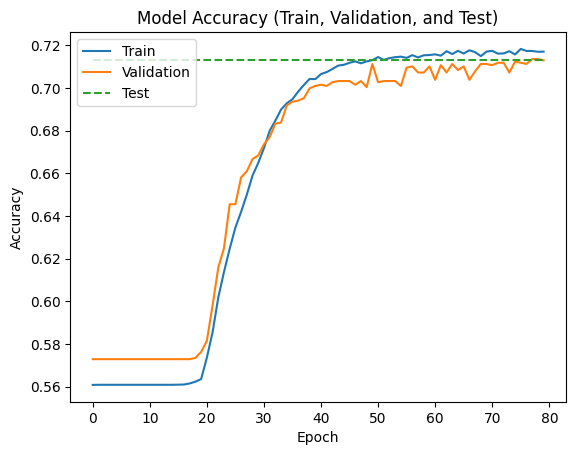

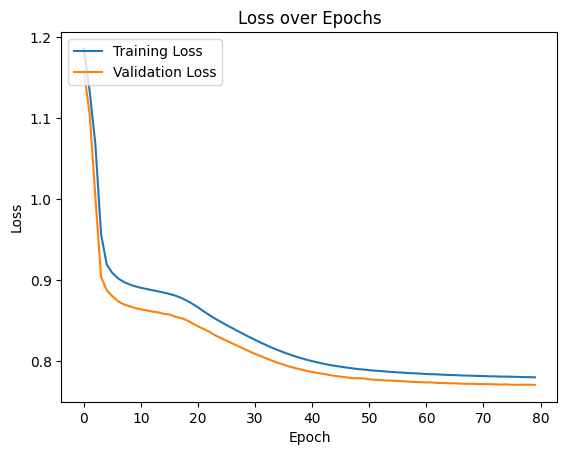

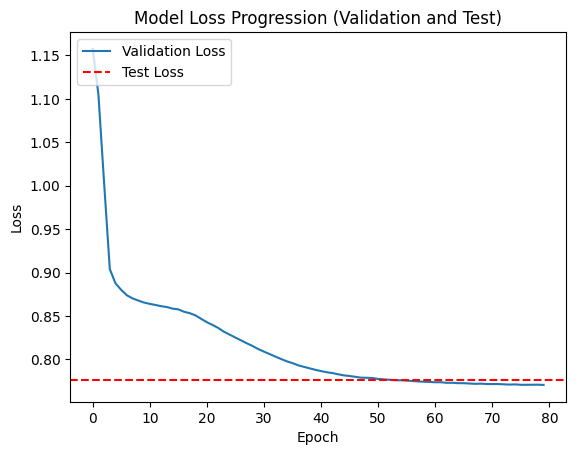

In [236]:
# Visualize Results

# Plot training, validation, and test accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.plot([test_acc]*len(history.history['accuracy']), label='Test', linestyle='--')
plt.title('Model Accuracy (Train, Validation, and Test)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


# Plot validation and test loss values
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Model Loss Progression (Validation and Test)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()



<h1>Results</h1>




The following graphs are for the base run of the project. Throughout the training, I implemented learning rate reduction technique with the hopes of reducing plateus that occur during the learning process.  The structure of the run is as follows.

- Run: Base
- Normalization: Yes
- Batch Size: 32
- Epochs: 80
- Learning Rate: 0.01
- Optimizer: Adam
- Initialization: Random
- Regularization: No
<h3>Graphs</h3>
<img src="Images/Base Run Model Accuracy.png">
<img src="Images/Base Run Loss.png">
<img src="Images/Base Model Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
Looking at the graph, it can be observed that the model's training accuracy steadily increases throughout each epoch, Indicating that the model is learning effectively from the data. It can also be observed that during the upward trend of the graph, the fluctuations becoem less and less pronounced. This indicates that the model is generalizing well to unseen validation data. By epoch 40, training and validation accuracies seems to stabalize, with the model acheiving around a 76% accuracy. 
<h3>Loss over Epochs</h3>
In this graph, the training loss shows a consistent downward trend, indicating that the model is minimizing its errors over time. The validation loss decreases similarly, although with higher fluctiations during the early epochs. Since the gap between training and validation loss is not significant, it can be assumed that the model is not overfitting to the training data. 
<h3>Model Loss Progression</h3>
In this graph, it can be observed that the validation loss decreases steadily, while the test loss remains constant. This suggests that the model has learned effectively from the training data and has generalized well to my unseen test data. 

<h2>Run 2</h2>


- Run: 2
- Normalization: No
- Batch Size: 32
- Epochs: 80
- Learning Rate: 0.01
- Optimizer: Adam
- Initialization: Random
- Regularization: Yes
<h3>Graphs</h3>
<img src="Images/Run 2 Accuracy.png">
<img src="Images/Run 2 Loss.png">
<img src="Images/Run 2 Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
The accuracy graph improves dramatically during the first few epochs. However, it seems to flatline after about 20 epochs, indicating that the model may not be learning effectively beyond a certain point. 
<h3>Loss over Epochs</h3>
The training and validation losses improve steadily during the first few epochs, but plateu around 0.72. This may suggest that the learning has slowed down too early. 
<h3>Model Loss Progression</h3>
The test loss flatlines at around 0.74. This suggests that this model configuration is not learning much from the training process after a certain point. 


<h2>Run 3</h2>

- Run:3
- Normalization: Yes
- Batch Size: 100
- Epochs: 80
- Learning Rate: 0.0001
- Optimizer: Momentum
- Initialization:Xavier
- Regularization:No
<h3>Graphs</h3>
<img src="Images/Run 3 Accuracy.png">
<img src="Images/Run 3 Loss.png">
<img src="Images/Run 3 Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
In this run, the accuracy shows a noticable increase compared to the previous run. The validation accuracy increases rapidly, plateuing near 0.75, while the test accuracy remains stable at around 0.72. This suggests that the model is learning more effectively in this configuration.
<h3>Loss over Epochs</h3>
Similarly with the accuracy graph, the loss over epochs shows significant improvement for both training and validation. They both decrease steadily over the epochs with validation loss plateuing around 0.65. This indicates that the model is converging well with this learning rate. However, the diffrence between training and validation loss is still present. This may indicate potential overfitting. 
<h3>Model Loss Progression</h3>
The test loss remains stable around 0.65, which suggests that the model is generalizing better to the test set with this configuration.

<h2>
Run 4
</h2>


- Run: 4
- Normalization: No
- Batch Size: 100
- Epochs: 80
- Learning Rate: 0.01
- Optimizer: Momentum
- Initialization: Xavier
- Regularization: Yes
<h3>Graphs</h3>
<img src="Images/Run 4 Accuracy.png">
<img src="Images/Run 4 Loss.png">
<img src="Images/Run 4 Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
This model's accuracy shows a steady increase and stabalizes around 68%. There is some fluctuation in the validation accuracy in early epochs, but both training and validation accuracy successfully converge. 
<h3>Loss over Epochs</h3>
The training and validation losses decrese in the first 10 epochs, reaching lower and stable level. However, the test loss, which is computed after training, is represented by a horizontal line and remains higher than the validation and training losses. This might indicate generalization issues. 
<h3>Model Loss Progression</h3>
The test loss remains relatively high, as shown by the horizontal line, suggesting that the model may not generalize well on onseen data. This may be due to overfitting, which could be mitigated by adjusting regularization, learning rate, or implementing strategies like early stopping.

<h2>
Run 5
</h2>


- Run: 5
- Normalization: Yes
- Batch Size: 32
- Epochs: 80
- Learning Rate: 0.0001
- Optimizer: Adam
- Initialization: Xavier
- Regularization: No
<h3>Graphs</h3>
<img src="Images/Run 5 Accuracy.png">
<img src="Images/Run 5 Loss.png">
<img src="Images/Run 5 Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
The accuracy plot shows a consistent increase in both training and validation accuracy, and converges at around 20 epochs at 75%.
<h3>Loss over Epochs</h3>
The training and validation losses both decrease during the first 10 epochs and continue to stabalize therafter. There is a minimal gap between training and validation loss, which sugguests that this configuration is generalizing well without overfitting. 
<h3>Model Loss Progression</h3>
The test loss is consistently lower than the validation loss throughout each epoch. This indicates that the model is performing well on onseen data. 

<h2>
Run 6
</h2>


- Run: 6
- Normalization: No 
- Batch Size: 32
- Epochs: 80
- Learning Rate: 0.01
- Optimizer: Momentum
- Initialization: Random
- Regularization: Yes
<h3>Graphs</h3>
<img src="Images/Run 6 Accuracy.png">
<img src="Images/Run 6 Loss.png">
<img src="Images/Run 6 Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
Using this configuration, accuracy increases steadily and stabilizes at around 68%. However, there are noticeable fluctuations in both the training and validation accuracy, especially at in the early epochs. 
<h3>Loss over Epochs</h3>
It can be observed that both training and validation losses experience a sharp initial drop during the first 10 epochs. The validation loss fluctuates and remains higher than the training loss, which can indicate that this configuration of the model struggles to generalize to my validation set. 
<h3>Model Loss Progression</h3>
Because of the relatively high validation and test losses paired with the difference between the training and validation losses may suggest overfitting. This could also be due to the higher learning rate or absence of normalization in this configuration. 

<h2>
Run 7
</h2>


- Run: 7
- Normalization: Yes
- Batch Size: 100
- Epochs: 80
- Learning Rate: 0.0001
- Optimizer: Adam
- Initialization: Random 
- Regularization: Yes
<h3>Graphs</h3>
<img src="Images/Run 7 Accuracy.png">
<img src="Images/Run 7 Loss.png">
<img src="Images/Run 7 Loss Progression.png">

<h2>Observations</h2>
<h3>Accuracy</h3>
It can be observed that the model converges smoothly to around 70% accuracy. This accuracy increases steadily over the initial epochs.
<h3>Loss over Epochs</h3>
Loss can be observed to decrease steadily across epochs, with this configuration showing minimal overfitting. This can be due to the smaller learning rate and regularization.

<h3>Model Loss Progression</h3>
Test loss is observed to stabilize well and align closely with validation loss. This indicates good generalization and stable performance on the unseen data. 